<a href="https://colab.research.google.com/github/callistacim/predict-bankrupt/blob/main/rev_tab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import os

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [17]:
file_path = '/content/project_ds.xlsx'
df = pd.read_excel(file_path)
df

,tanggal,total_order,total_pickup,total_delivery,total_pickup_delivery,total_cancel,total_bookings,total_revenue,PnL_rev
0,2023-12-01,355401.0,329764,321474.0,651238.0,6104.0,356143,3.235842e+09,3.253848e+09
1,2023-12-02,328939.0,336808,377766.0,714574.0,4204.0,328753,3.504525e+09,3.524025e+09
2,2023-12-03,205178.0,49381,13179.0,62560.0,2947.0,216785,2.367166e+08,2.380338e+08
3,2023-12-04,545267.0,600819,435942.0,1036761.0,5838.0,538934,4.356612e+09,4.380855e+09
4,2023-12-05,404052.0,440086,422757.0,862843.0,4743.0,404230,3.755460e+09,3.776357e+09
...,...,...,...,...,...,...,...,...,...
361,2024-11-26,498380.0,540092,409349.0,949441.0,4580.0,497548,4.382521e+09,4.419282e+09
362,2024-11-27,320674.0,208457,281884.0,490341.0,3478.0,327388,2.841637e+09,2.865473e+09
363,2024-11-28,531038.0,594200,592414.0,1186614.0,10251.0,529318,6.462585e+09,6.516793e+09
364,2024-11-29,438062.0,451575,452509.0,904084.0,6831.0,439553,5.147265e+09,5.190440e+09


check null value

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tanggal                366 non-null    datetime64[ns]
 1   total_order            364 non-null    float64       
 2   total_pickup           366 non-null    int64         
 3   total_delivery         364 non-null    float64       
 4   total_pickup_delivery  364 non-null    float64       
 5   total_cancel           364 non-null    float64       
 6   total_bookings         366 non-null    int64         
 7   total_revenue          366 non-null    float64       
 8   PnL_rev                366 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 25.9 KB


In [19]:
print(df.isnull().sum())

tanggal                  0
total_order              2
total_pickup             0
total_delivery           2
total_pickup_delivery    2
total_cancel             2
total_bookings           0
total_revenue            0
PnL_rev                  0
dtype: int64


In [20]:
df['total_order'] = df['total_order'].fillna(0).astype(int)
df['total_delivery'] = df['total_delivery'].fillna(0).astype(int)
df['total_pickup_delivery'] = df['total_pickup_delivery'].fillna(0).astype(int)
df['total_cancel'] = df['total_cancel'].fillna(0).astype(int)
df['total_revenue'] = df['total_revenue'].fillna(0).astype(int)
# Ensure 'PnL_rev' is treated as a string before using .str
df['PnL_rev'] = df['PnL_rev'].astype(str)
df['PnL_rev'] = pd.to_numeric(df['PnL_rev'].str.replace(' ', ''), errors='coerce').fillna(0).astype(int)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tanggal                366 non-null    datetime64[ns]
 1   total_order            366 non-null    int64         
 2   total_pickup           366 non-null    int64         
 3   total_delivery         366 non-null    int64         
 4   total_pickup_delivery  366 non-null    int64         
 5   total_cancel           366 non-null    int64         
 6   total_bookings         366 non-null    int64         
 7   total_revenue          366 non-null    int64         
 8   PnL_rev                366 non-null    int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 25.9 KB


In [22]:
df.dropna()

,tanggal,total_order,total_pickup,total_delivery,total_pickup_delivery,total_cancel,total_bookings,total_revenue,PnL_rev
0,2023-12-01,355401,329764,321474,651238,6104,356143,3235842325,3253848075
1,2023-12-02,328939,336808,377766,714574,4204,328753,3504524553,3524025378
2,2023-12-03,205178,49381,13179,62560,2947,216785,236716623,238033825
3,2023-12-04,545267,600819,435942,1036761,5838,538934,4356612374,4380854617
4,2023-12-05,404052,440086,422757,862843,4743,404230,3755460221,3776357370
...,...,...,...,...,...,...,...,...,...
361,2024-11-26,498380,540092,409349,949441,4580,497548,4382520869,4419281505
362,2024-11-27,320674,208457,281884,490341,3478,327388,2841637270,2865472956
363,2024-11-28,531038,594200,592414,1186614,10251,529318,6462585201,6516793441
364,2024-11-29,438062,451575,452509,904084,6831,439553,5147265076,5190440396


add col holiday

In [23]:
pip install holidays


In [24]:
import holidays

# Get Indonesian holidays for a specific year (e.g., 2024)
indonesia_holidays = holidays.Indonesia(years=2024)

# Print all holidays
for date, name in sorted(indonesia_holidays.items()):
    print(date, name)


2024-01-01 New Year's Day
2024-02-08 Isra' and Mi'raj
2024-02-10 Lunar New Year
2024-02-14 General Election Day
2024-03-11 Day of Silence
2024-03-29 Good Friday
2024-03-31 Easter Sunday
2024-04-10 Eid al-Fitr
2024-04-11 Eid al-Fitr Second Day
2024-05-01 International Labor Day
2024-05-09 Ascension Day
2024-05-23 Vesak Day
2024-06-01 Pancasila Day
2024-06-17 Eid al-Adha
2024-07-07 Islamic New Year
2024-08-17 Independence Day
2024-09-16 Prophet's Birthday
2024-11-27 Local Election Day
2024-12-25 Christmas Day


In [25]:
df['tanggal'] = pd.to_datetime(df['tanggal'])

In [26]:
import holidays
import datetime # Import the datetime module

# Get Indonesian holidays for a specific year (e.g., 2024)
indonesia_holidays = holidays.Indonesia(years=2024)

# Print all holidays
for date, name in sorted(indonesia_holidays.items()):
    print(date, name)

# Example: Check if a given date is a holiday
def is_holiday(date):
    for holiday in indonesia_holidays:
        if holiday[0] == date:
            return holiday[1]
    return None

# Function to check if a date is a holiday
def check (date):
    # Convert the pandas Timestamp to a datetime.date object
    date_object = date.to_pydatetime().date()
    return "Holiday" if date_object in indonesia_holidays else "Not Holiday"

# Apply the function to create the 'Holiday' column
df['Holiday'] = df['tanggal'].apply(check)

# Display the DataFrame
print(df)

2024-01-01 New Year's Day
2024-02-08 Isra' and Mi'raj
2024-02-10 Lunar New Year
2024-02-14 General Election Day
2024-03-11 Day of Silence
2024-03-29 Good Friday
2024-03-31 Easter Sunday
2024-04-10 Eid al-Fitr
2024-04-11 Eid al-Fitr Second Day
2024-05-01 International Labor Day
2024-05-09 Ascension Day
2024-05-23 Vesak Day
2024-06-01 Pancasila Day
2024-06-17 Eid al-Adha
2024-07-07 Islamic New Year
2024-08-17 Independence Day
2024-09-16 Prophet's Birthday
2024-11-27 Local Election Day
2024-12-25 Christmas Day
       tanggal  total_order  total_pickup  total_delivery  \
0   2023-12-01       355401        329764          321474   
1   2023-12-02       328939        336808          377766   
2   2023-12-03       205178         49381           13179   
3   2023-12-04       545267        600819          435942   
4   2023-12-05       404052        440086          422757   
..         ...          ...           ...             ...   
361 2024-11-26       498380        540092          409349   

add col twin date

In [27]:
import pandas as pd
import datetime

twin_dates = [
    datetime.date(2024, 1, 1),  # January 1st
    datetime.date(2024, 2, 2),  # February 2nd
    datetime.date(2024, 3, 3),  # March 3rd
    datetime.date(2024, 4, 4),  # April 4th
    datetime.date(2024, 5, 5),  # May 5th
    datetime.date(2024, 6, 6),  # June 6th
    datetime.date(2024, 7, 7),  # July 7th
    datetime.date(2024, 8, 8),  # August 8th
    datetime.date(2024, 9, 9),  # September 9th
    datetime.date(2024, 10, 10), # October 10th
    datetime.date(2024, 11, 11),  # November 11th
    datetime.date(2024, 12, 12)  # Dec 12th
]

# Convert 'tanggal' column to datetime format
df['tanggal'] = pd.to_datetime(df['tanggal']).dt.date

# Function to check if the date is a twin date (month == day)
def check_twin_date(date):
    # Check if the date is in the list of twin dates
    if date in twin_dates:
        return 'Yes'  # Twin date found
    return 'No'  # Not a twin date

# Apply the function to create the 'Twin Date' column
df['Twin Date'] = df['tanggal'].apply(check_twin_date)

# Display the DataFrame
print(df)


        tanggal  total_order  total_pickup  total_delivery  \
0    2023-12-01       355401        329764          321474   
1    2023-12-02       328939        336808          377766   
2    2023-12-03       205178         49381           13179   
3    2023-12-04       545267        600819          435942   
4    2023-12-05       404052        440086          422757   
..          ...          ...           ...             ...   
361  2024-11-26       498380        540092          409349   
362  2024-11-27       320674        208457          281884   
363  2024-11-28       531038        594200          592414   
364  2024-11-29       438062        451575          452509   
365  2024-11-30       397095        415831          434194   

     total_pickup_delivery  total_cancel  total_bookings  total_revenue  \
0                   651238          6104          356143     3235842325   
1                   714574          4204          328753     3504524553   
2                    62560    

In [28]:
df.head(10)

,tanggal,total_order,total_pickup,total_delivery,total_pickup_delivery,total_cancel,total_bookings,total_revenue,PnL_rev,Holiday,Twin Date
0,2023-12-01,355401,329764,321474,651238,6104,356143,3235842325,3253848075,Not Holiday,No
1,2023-12-02,328939,336808,377766,714574,4204,328753,3504524553,3524025378,Not Holiday,No
2,2023-12-03,205178,49381,13179,62560,2947,216785,236716623,238033825,Not Holiday,No
3,2023-12-04,545267,600819,435942,1036761,5838,538934,4356612374,4380854617,Not Holiday,No
4,2023-12-05,404052,440086,422757,862843,4743,404230,3755460221,3776357370,Not Holiday,No
5,2023-12-06,383024,396109,451579,847688,4713,383961,4015738399,4038083858,Not Holiday,No
6,2023-12-07,361369,367295,447253,814548,5272,361513,4042204728,4064697459,Not Holiday,No
7,2023-12-08,340207,343237,388127,731364,6458,340508,3767217826,3788180400,Not Holiday,No
8,2023-12-09,290664,313216,326823,640039,4534,290816,3308727097,3327138413,Not Holiday,No
9,2023-12-10,180824,40263,12862,53125,3070,191449,268951814,270448389,Not Holiday,No


In [29]:
def check(tanggal):
    # Check if the date is a holiday or a Sunday (weekday() == 6)
    is_holiday = tanggal in indonesia_holidays # Removed .date()
    is_sunday = tanggal.weekday() == 6  # 6 represents Sunday

    # Return "Holiday" if either condition is True
    return "Holiday" if is_holiday or is_sunday else "Not Holiday"

# Apply the function to create the 'Holiday' column
df['Holiday'] = df['tanggal'].apply(check)

In [30]:
df['Holiday'].value_counts()


,count
Holiday,
Not Holiday,297
Holiday,69


In [31]:
print(df['Holiday'].head(10))    # 6 is Sunday = Holiday

0    Not Holiday
1    Not Holiday
2        Holiday
3    Not Holiday
4    Not Holiday
5    Not Holiday
6    Not Holiday
7    Not Holiday
8    Not Holiday
9        Holiday
Name: Holiday, dtype: object


In [32]:
df.head(10)

,tanggal,total_order,total_pickup,total_delivery,total_pickup_delivery,total_cancel,total_bookings,total_revenue,PnL_rev,Holiday,Twin Date
0,2023-12-01,355401,329764,321474,651238,6104,356143,3235842325,3253848075,Not Holiday,No
1,2023-12-02,328939,336808,377766,714574,4204,328753,3504524553,3524025378,Not Holiday,No
2,2023-12-03,205178,49381,13179,62560,2947,216785,236716623,238033825,Holiday,No
3,2023-12-04,545267,600819,435942,1036761,5838,538934,4356612374,4380854617,Not Holiday,No
4,2023-12-05,404052,440086,422757,862843,4743,404230,3755460221,3776357370,Not Holiday,No
5,2023-12-06,383024,396109,451579,847688,4713,383961,4015738399,4038083858,Not Holiday,No
6,2023-12-07,361369,367295,447253,814548,5272,361513,4042204728,4064697459,Not Holiday,No
7,2023-12-08,340207,343237,388127,731364,6458,340508,3767217826,3788180400,Not Holiday,No
8,2023-12-09,290664,313216,326823,640039,4534,290816,3308727097,3327138413,Not Holiday,No
9,2023-12-10,180824,40263,12862,53125,3070,191449,268951814,270448389,Holiday,No


In [33]:
# for col in df.columns:
#     if df[col].dtype in ['int64', 'float64']:
#         df[col] = df[col].apply(lambda x: "{:.}".format(x))  # For commas as thousand separator

## Encode

In [34]:
df['Holiday'] = df['Holiday'].map({'Holiday': 1, 'Not Holiday': 0})


In [35]:
df['Twin Date'] = df['Twin Date'].map({'Yes': 1, 'No': 0})


In [36]:
# check dtype
df.dtypes

,0
tanggal,object
total_order,int64
total_pickup,int64
total_delivery,int64
total_pickup_delivery,int64
total_cancel,int64
total_bookings,int64
total_revenue,int64
PnL_rev,int64
Holiday,int64


# CORRELATION

In [37]:
drop_col_corr = ['PnL_rev','tanggal']
correlation_matrix = df.drop(columns=drop_col_corr).corr()

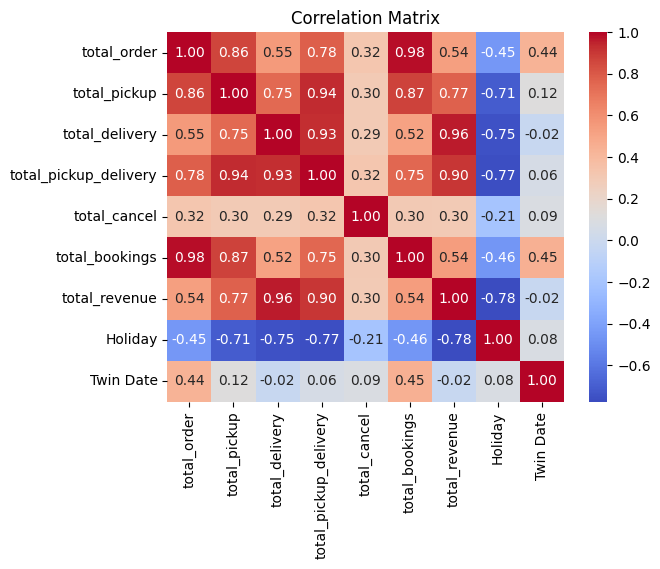

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [39]:
# highest to lowest corr for 'total_rev'
sorted_corr = correlation_matrix['total_revenue'].sort_values(ascending=False)
sorted_corr

,total_revenue
total_revenue,1.000000
total_delivery,0.959989
total_pickup_delivery,0.903876
total_pickup,0.773102
total_bookings,0.538253
total_order,0.535363
total_cancel,0.298928
Twin Date,-0.023164
Holiday,-0.775194


## Corr Delivery

In [40]:
sorted_corr = correlation_matrix['total_delivery'].sort_values(ascending=False)
sorted_corr

,total_delivery
total_delivery,1.000000
total_revenue,0.959989
total_pickup_delivery,0.927162
total_pickup,0.750046
total_order,0.550645
total_bookings,0.515398
total_cancel,0.294429
Twin Date,-0.021983
Holiday,-0.752703


## Corr Bookings

In [41]:
sorted_corr = correlation_matrix['total_bookings'].sort_values(ascending=False)
sorted_corr

,total_bookings
total_bookings,1.000000
total_order,0.980339
total_pickup,0.870478
total_pickup_delivery,0.750460
total_revenue,0.538253
total_delivery,0.515398
Twin Date,0.450020
total_cancel,0.303902
Holiday,-0.456339


There are only a limited number of twin dates in a full year. DS doesn't hv enuf data points for twin dates, it could make it difficult to accurately capture the correlation-> lower correlation value than expected.

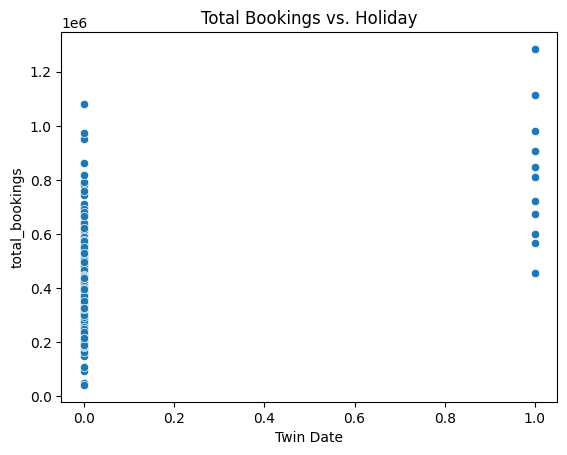

In [42]:
# Scatter plot of 'total_bookings' vs. 'Twin Date'
sns.scatterplot(x='Twin Date', y='total_bookings', data=df)
plt.title('Total Bookings vs. Holiday')
plt.show()

In [43]:
# for i in range(1,12)
#   col_name = 'day'

In [44]:
df

,tanggal,total_order,total_pickup,total_delivery,total_pickup_delivery,total_cancel,total_bookings,total_revenue,PnL_rev,Holiday,Twin Date
0,2023-12-01,355401,329764,321474,651238,6104,356143,3235842325,3253848075,0,0
1,2023-12-02,328939,336808,377766,714574,4204,328753,3504524553,3524025378,0,0
2,2023-12-03,205178,49381,13179,62560,2947,216785,236716623,238033825,1,0
3,2023-12-04,545267,600819,435942,1036761,5838,538934,4356612374,4380854617,0,0
4,2023-12-05,404052,440086,422757,862843,4743,404230,3755460221,3776357370,0,0
...,...,...,...,...,...,...,...,...,...,...,...
361,2024-11-26,498380,540092,409349,949441,4580,497548,4382520869,4419281505,0,0
362,2024-11-27,320674,208457,281884,490341,3478,327388,2841637270,2865472956,1,0
363,2024-11-28,531038,594200,592414,1186614,10251,529318,6462585201,6516793441,0,0
364,2024-11-29,438062,451575,452509,904084,6831,439553,5147265076,5190440396,0,0


In [45]:
df.to_excel('cleaned_ds.xlsx')

# Monthly

In [268]:
import pandas as pd

# Assuming your data is already loaded into a dataframe called 'df'
# Convert 'tanggal' to datetime format
df['tanggal'] = pd.to_datetime(df['tanggal'])

# Extract the month and year from 'tanggal' to group by month
df['month'] = df['tanggal'].dt.to_period('M')

# Aggregate the necessary columns by summing them
monthly_data = df.groupby('month').agg({
    'total_order': 'sum',
    'total_pickup': 'sum',
    'total_delivery': 'sum',
    'total_pickup_delivery': 'sum',
    'total_cancel': 'sum',
    'total_bookings': 'sum',
    'total_revenue': 'sum',
    'PnL_rev': 'sum',
    'Holiday': 'max',  # 'max' is used to pick the occurrence of a holiday
    'Twin Date': 'sum'  # Assuming you want the total number of twin dates in the month
}).reset_index()

# Print the resulting monthly data
print(monthly_data)

      month  total_order  total_pickup  total_delivery  total_pickup_delivery  \
0   2023-12     11599431      11355052        11081582               22436634   
1   2024-01     10892539      10791727        10746669               21538396   
2   2024-02     11715135      11508564        11090374               22598938   
3   2024-03     13554745      13051053        12785333               25836386   
4   2024-04     10657935      10728960        10670322               21399282   
5   2024-05     11878057      11698490        11675577               23374067   
6   2024-06     11385578      11910968        10986575               22084943   
7   2024-07     12819344      12606959        12172495               24779454   
8   2024-08     13411845      13286769        13405685               26692454   
9   2024-09     13464080      13247899        12980604               26228503   
10  2024-10     14148327      14000089        14083839               28083928   
11  2024-11     13667724    

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

       month  predicted_sales
0 2024-11-30     1.570581e+11


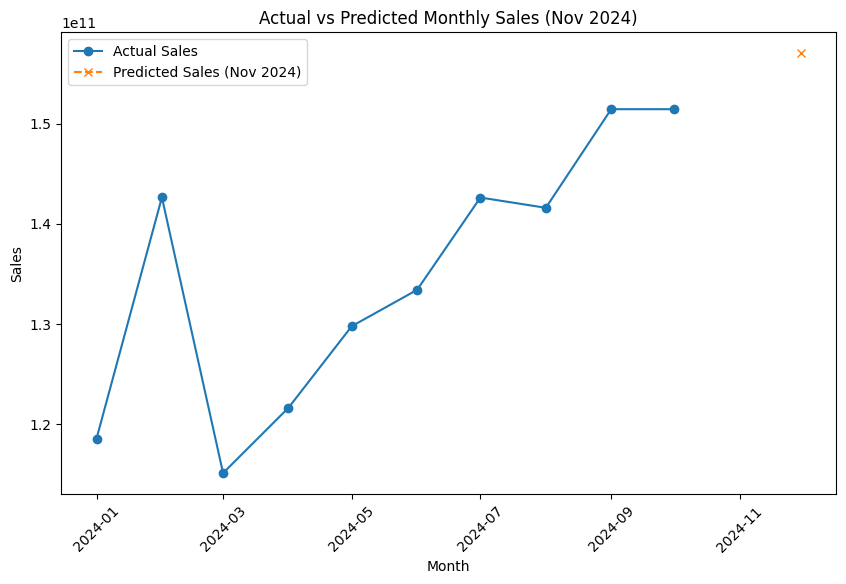

In [279]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Input data with revenue from Dec 2023 to Oct 2024
data = {
    'month': ['2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07',
              '2024-08', '2024-09', '2024-10'],
    'total_revenue': [
        112732159295, 118510679557, 142635556169, 115071446043,
        121597997261, 129753419745, 133389186927, 142615265729,
        141589984762, 151448351468, 151448351468  # Corrected value for October 2024
    ]
}

# Create DataFrame
monthly_data = pd.DataFrame(data)

# Convert 'month' to datetime format
monthly_data['month'] = pd.to_datetime(monthly_data['month'], format='%Y-%m')

# Calculate the difference in sales (month-to-month difference)
monthly_data['sales_diff'] = monthly_data['total_revenue'].diff()

# Drop the first row since diff() will create a NaN for the first value
monthly_data = monthly_data.dropna()

# Fit ARIMA model to the sales_diff
model = sm.tsa.ARIMA(monthly_data['sales_diff'], order=(1, 0, 0))  # ARIMA(p, d, q), with simple (1, 0, 0) parameters
model_fit = model.fit()

# Predict the next month (November 2024)
forecast_steps = 1
forecast_diff = model_fit.forecast(steps=forecast_steps)

# Predict future sales using the forecasted differences
# For the first forecasted value, we need to add the forecasted diff to the last known sales
predicted_sales = []
last_known_sales = monthly_data['total_revenue'].iloc[-1]

for diff in forecast_diff:
    predicted_sales.append(last_known_sales + diff)
    last_known_sales += diff  # Update the last known sales

# Create a DataFrame for the forecasted month (November 2024)
forecast_months = pd.date_range(start=monthly_data['month'].iloc[-1], periods=forecast_steps + 1, freq='M')[1:]

forecast_df = pd.DataFrame({
    'month': forecast_months,
    'predicted_sales': predicted_sales
})

# Display the forecast
print(forecast_df)

# Plot the actual and predicted sales
plt.figure(figsize=(10, 6))
plt.plot(monthly_data['month'], monthly_data['total_revenue'], label='Actual Sales', marker='o')
plt.plot(forecast_df['month'], forecast_df['predicted_sales'], label='Predicted Sales (Nov 2024)', marker='x', linestyle='--')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Monthly Sales (Nov 2024)')
plt.legend()
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

       month  predicted_sales  actual_sales
0 2024-11-30     1.570581e+11  144785247156


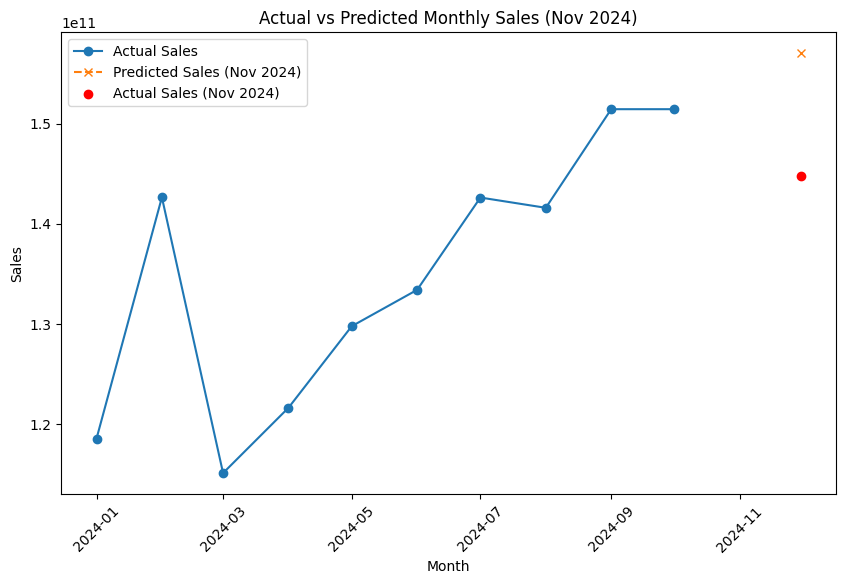

In [280]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Input data with revenue from Dec 2023 to Oct 2024
data = {
    'month': ['2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07',
              '2024-08', '2024-09', '2024-10'],
    'total_revenue': [
        112732159295, 118510679557, 142635556169, 115071446043,
        121597997261, 129753419745, 133389186927, 142615265729,
        141589984762, 151448351468, 151448351468  # Corrected value for October 2024
    ]
}

# Create DataFrame
monthly_data = pd.DataFrame(data)

# Convert 'month' to datetime format
monthly_data['month'] = pd.to_datetime(monthly_data['month'], format='%Y-%m')

# Calculate the difference in sales (month-to-month difference)
monthly_data['sales_diff'] = monthly_data['total_revenue'].diff()

# Drop the first row since diff() will create a NaN for the first value
monthly_data = monthly_data.dropna()

# Fit ARIMA model to the sales_diff
model = sm.tsa.ARIMA(monthly_data['sales_diff'], order=(1, 0, 0))  # ARIMA(p, d, q), with simple (1, 0, 0) parameters
model_fit = model.fit()

# Predict the next month (November 2024)
forecast_steps = 1
forecast_diff = model_fit.forecast(steps=forecast_steps)

# Predict future sales using the forecasted differences
# For the first forecasted value, we need to add the forecasted diff to the last known sales
predicted_sales = []
last_known_sales = monthly_data['total_revenue'].iloc[-1]

for diff in forecast_diff:
    predicted_sales.append(last_known_sales + diff)
    last_known_sales += diff  # Update the last known sales

# Create a DataFrame for the forecasted month (November 2024)
forecast_months = pd.date_range(start=monthly_data['month'].iloc[-1], periods=forecast_steps + 1, freq='M')[1:]

forecast_df = pd.DataFrame({
    'month': forecast_months,
    'predicted_sales': predicted_sales
})

# Actual sales for November 2024
actual_november_sales = 144785247156

# Add actual November sales to the forecast dataframe
forecast_df['actual_sales'] = actual_november_sales

# Display the forecast and actual sales
print(forecast_df)

# Plot the actual and predicted sales, including the actual November sales
plt.figure(figsize=(10, 6))
plt.plot(monthly_data['month'], monthly_data['total_revenue'], label='Actual Sales', marker='o')
plt.plot(forecast_df['month'], forecast_df['predicted_sales'], label='Predicted Sales (Nov 2024)', marker='x', linestyle='--')
plt.scatter(forecast_df['month'], forecast_df['actual_sales'], color='red', label='Actual Sales (Nov 2024)', zorder=5)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Monthly Sales (Nov 2024)')
plt.legend()
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Predicted November 2024 Sales: 142,476,171,293
Actual November 2024 Sales: 144,785,247,156


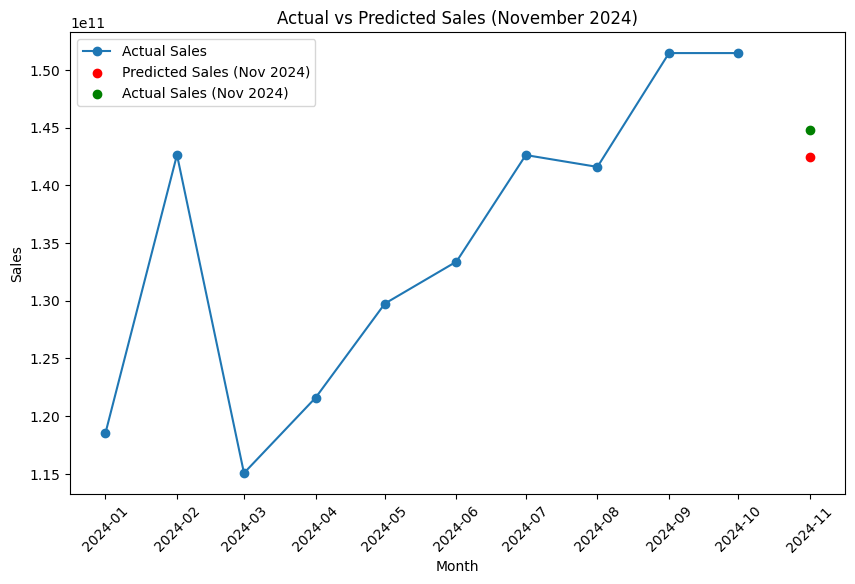

In [285]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Input data with revenue from Dec 2023 to Oct 2024
data = {
    'month': ['2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07',
              '2024-08', '2024-09', '2024-10'],
    'total_revenue': [
        112732159295, 118510679557, 142635556169, 115071446043,
        121597997261, 129753419745, 133389186927, 142615265729,
        141589984762, 151448351468, 151448351468  # Corrected value for October 2024
    ]
}

# Create DataFrame
monthly_data = pd.DataFrame(data)

# Convert 'month' to datetime format
monthly_data['month'] = pd.to_datetime(monthly_data['month'], format='%Y-%m')

# Create features from the data for Random Forest prediction
# Use previous month's sales as features
monthly_data['previous_month_sales'] = monthly_data['total_revenue'].shift(1)

# Drop the first row due to NaN value from shifting
monthly_data = monthly_data.dropna()

# Define the feature columns (X) and target column (y)
X = monthly_data[['previous_month_sales']]
y = monthly_data['total_revenue']

# Train Random Forest model
rf_model = RandomForestRegressor()
rf_model.fit(X, y)

# Predict for November (use October sales as the input feature)
november_sales_pred = rf_model.predict([[monthly_data['total_revenue'].iloc[-1]]])

# Actual sales for November 2024 (to compare)
actual_november_sales = 144785247156

# Print the predicted and actual sales for November
print(f"Predicted November 2024 Sales: {november_sales_pred[0]:,.0f}")
print(f"Actual November 2024 Sales: {actual_november_sales:,.0f}")

# Plot the actual vs predicted sales
plt.figure(figsize=(10, 6))
plt.plot(monthly_data['month'], monthly_data['total_revenue'], label='Actual Sales', marker='o')
plt.scatter(pd.to_datetime('2024-11'), november_sales_pred, color='red', label='Predicted Sales (Nov 2024)', zorder=5)
plt.scatter(pd.to_datetime('2024-11'), actual_november_sales, color='green', label='Actual Sales (Nov 2024)', zorder=5)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales (November 2024)')
plt.legend()
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Predicted November 2024 Sales: 144,937,960,931
Actual November 2024 Sales: 144,785,247,156


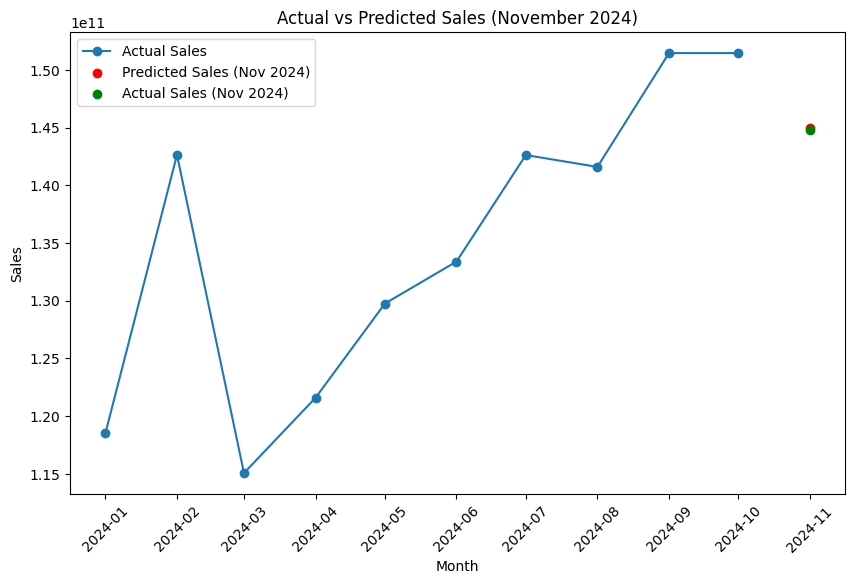

In [287]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Input data with revenue from Dec 2023 to Oct 2024
data = {
    'month': ['2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07',
              '2024-08', '2024-09', '2024-10'],
    'total_revenue': [
        112732159295, 118510679557, 142635556169, 115071446043,
        121597997261, 129753419745, 133389186927, 142615265729,
        141589984762, 151448351468, 151448351468  # Corrected value for October 2024
    ]
}

# Create DataFrame
monthly_data = pd.DataFrame(data)

# Convert 'month' to datetime format
monthly_data['month'] = pd.to_datetime(monthly_data['month'], format='%Y-%m')

# Create features from the data for Random Forest prediction
# Use previous month's sales as features
monthly_data['previous_month_sales'] = monthly_data['total_revenue'].shift(1)

# Drop the first row due to NaN value from shifting
monthly_data = monthly_data.dropna()

# Define the feature columns (X) and target column (y)
X = monthly_data[['previous_month_sales']]
y = monthly_data['total_revenue']

# Train Random Forest model
rf_model = RandomForestRegressor()
rf_model.fit(X, y)

# Predict for November (use October sales as the input feature)
november_sales_pred = rf_model.predict([[monthly_data['total_revenue'].iloc[-1]]])

# Actual sales for November 2024 (to compare)
actual_november_sales = 144785247156

# Print the predicted and actual sales for November
print(f"Predicted November 2024 Sales: {november_sales_pred[0]:,.0f}")
print(f"Actual November 2024 Sales: {actual_november_sales:,.0f}")

# Plot the actual vs predicted sales
plt.figure(figsize=(10, 6))
plt.plot(monthly_data['month'], monthly_data['total_revenue'], label='Actual Sales', marker='o')
plt.scatter(pd.to_datetime('2024-11'), november_sales_pred, color='red', label='Predicted Sales (Nov 2024)', zorder=5)
plt.scatter(pd.to_datetime('2024-11'), actual_november_sales, color='green', label='Actual Sales (Nov 2024)', zorder=5)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales (November 2024)')
plt.legend()
plt.xticks(rotation=45)
plt.show()


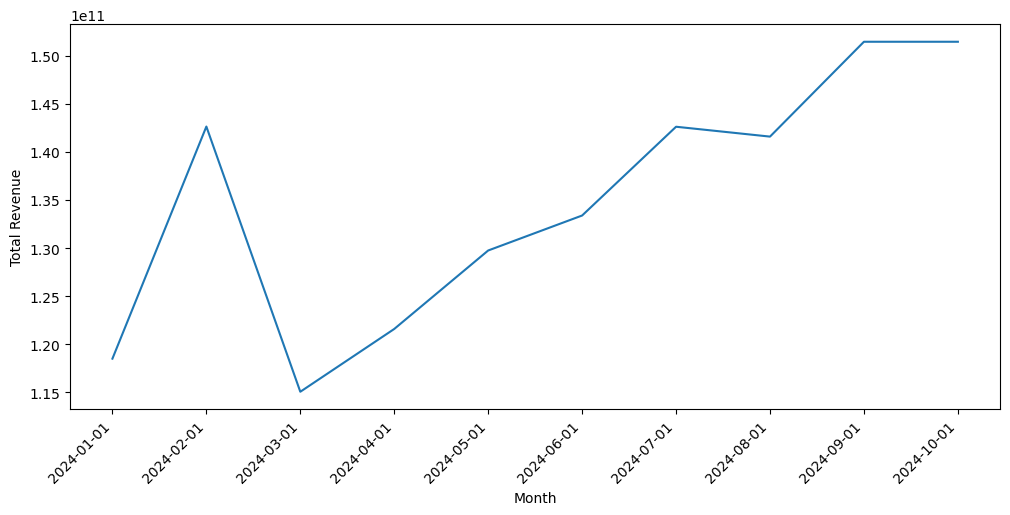

In [283]:
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas if you haven't already

# ... (Your previous code to create monthly_data) ...

# Convert the 'month' column to strings before plotting
plt.figure(figsize=(12, 5))
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.plot(monthly_data['month'].astype(str), monthly_data['total_revenue']) # Convert to string
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability (optional)
plt.show()

In [270]:
monthly_data['sales_diff'] = monthly_data['total_revenue'].diff()
monthly_data = monthly_data.dropna()
monthly_data.head(10)

,month,total_order,total_pickup,total_delivery,total_pickup_delivery,total_cancel,total_bookings,total_revenue,PnL_rev,Holiday,Twin Date,sales_diff
1,2024-01,10892539,10791727,10746669,21538396,148756,10932800,112732159295,113215876096,1,1,4.324569e+09
2,2024-02,11715135,11508564,11090374,22598938,162579,11545089,118510679557,118788641817,1,1,5.778520e+09
3,2024-03,13554745,13051053,12785333,25836386,203351,13611539,142635556169,144010788390,1,1,2.412488e+10
4,2024-04,10657935,10728960,10670322,21399282,212587,10688422,115071446043,117912854676,1,1,-2.756411e+10
5,2024-05,11878057,11698490,11675577,23374067,169290,11781329,121597997261,120760824855,1,1,6.526551e+09
6,2024-06,11385578,11910968,10986575,22084943,153576,12217203,129753419745,130836641583,1,1,8.155422e+09
7,2024-07,12819344,12606959,12172495,24779454,246092,12855029,133389186927,134374610757,1,1,3.635767e+09
8,2024-08,13411845,13286769,13405685,26692454,206322,13444191,142615265729,143335722064,1,1,9.226079e+09
9,2024-09,13464080,13247899,12980604,26228503,182794,13516407,141589984762,142371134793,1,1,-1.025281e+09
10,2024-10,14148327,14000089,14083839,28083928,167488,14216165,151448351468,143474928812,1,1,9.858367e+09


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

       month  predicted_sales
0 2024-06-30     1.187699e+11


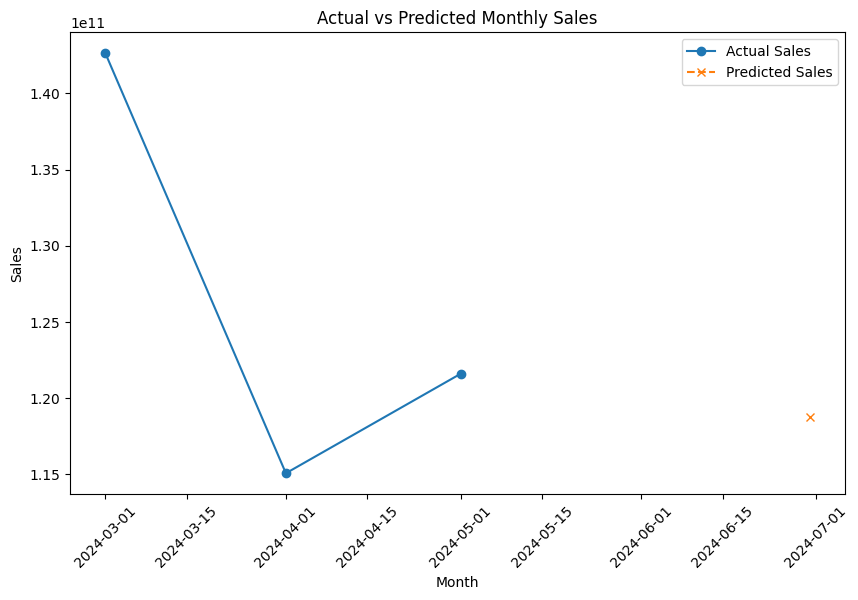

In [278]:
# Convert 'month' to datetime format
monthly_data['month'] = pd.to_datetime(monthly_data['month'], format='%Y-%m')

# Calculate the difference in sales (month-to-month difference)
monthly_data['sales_diff'] = monthly_data['total_revenue'].diff()

# Drop the first row since diff() will create a NaN for the first value
monthly_data = monthly_data.dropna()

# Fit ARIMA model to the sales_diff
model = sm.tsa.ARIMA(monthly_data['sales_diff'], order=(1, 0, 0))  # ARIMA(p, d, q), with simple (1, 0, 0) parameters
model_fit = model.fit()

# Predict the next few months (e.g., next 3 months)
forecast_steps = 1
forecast_diff = model_fit.forecast(steps=forecast_steps)

# Predict future sales using the forecasted differences
# For the first forecasted value, we need to add the forecasted diff to the last known sales
predicted_sales = []
last_known_sales = monthly_data['total_revenue'].iloc[-1]

for diff in forecast_diff:
    predicted_sales.append(last_known_sales + diff)
    last_known_sales += diff  # Update the last known sales

# Create a DataFrame for the forecasted months
forecast_months = pd.date_range(start=monthly_data['month'].iloc[-1], periods=forecast_steps + 1, freq='M')[1:]

forecast_df = pd.DataFrame({
    'month': forecast_months,
    'predicted_sales': predicted_sales
})

# Display the forecast
print(forecast_df)

# Plot the actual and predicted sales
plt.figure(figsize=(10, 6))
plt.plot(monthly_data['month'], monthly_data['total_revenue'], label='Actual Sales', marker='o')
plt.plot(forecast_df['month'], forecast_df['predicted_sales'], label='Predicted Sales', marker='x', linestyle='--')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Monthly Sales')
plt.legend()
plt.xticks(rotation=45)
plt.show()

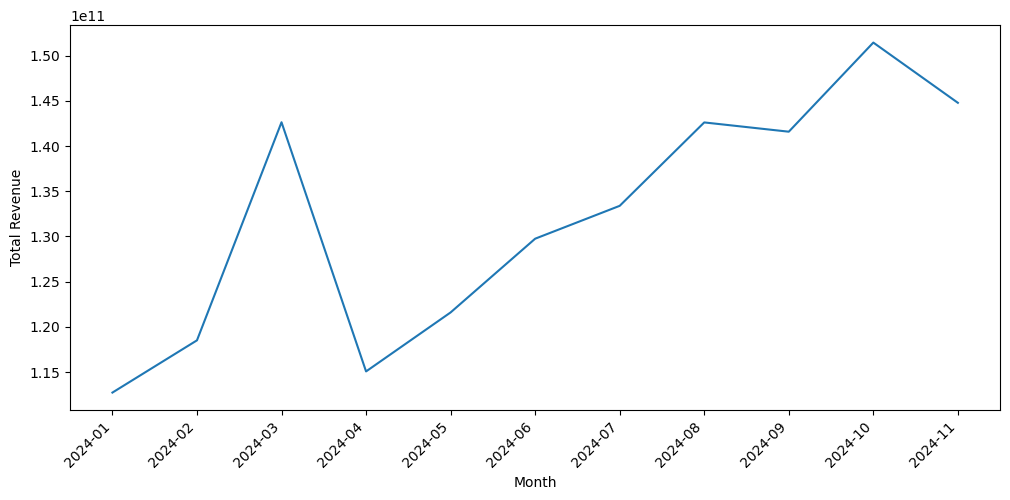

In [271]:
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas if you haven't already

# ... (Your previous code to create monthly_data) ...

# Convert the 'month' column to strings before plotting
plt.figure(figsize=(12, 5))
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.plot(monthly_data['month'].astype(str), monthly_data['total_revenue']) # Convert to string
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability (optional)
plt.show()

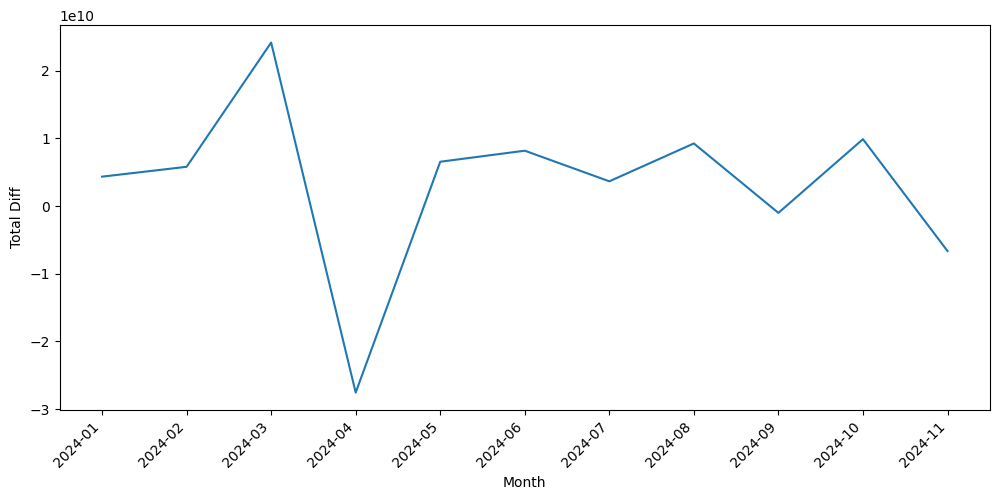

In [272]:
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas if you haven't already

# ... (Your previous code to create monthly_data) ...

# Convert the 'month' column to strings before plotting
plt.figure(figsize=(12, 5))
plt.xlabel("Month")
plt.ylabel("Total Diff")
plt.plot(monthly_data['month'].astype(str), monthly_data['sales_diff']) # Convert to string
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability (optional)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

       month  predicted_sales
0 2024-06-30     1.226489e+11


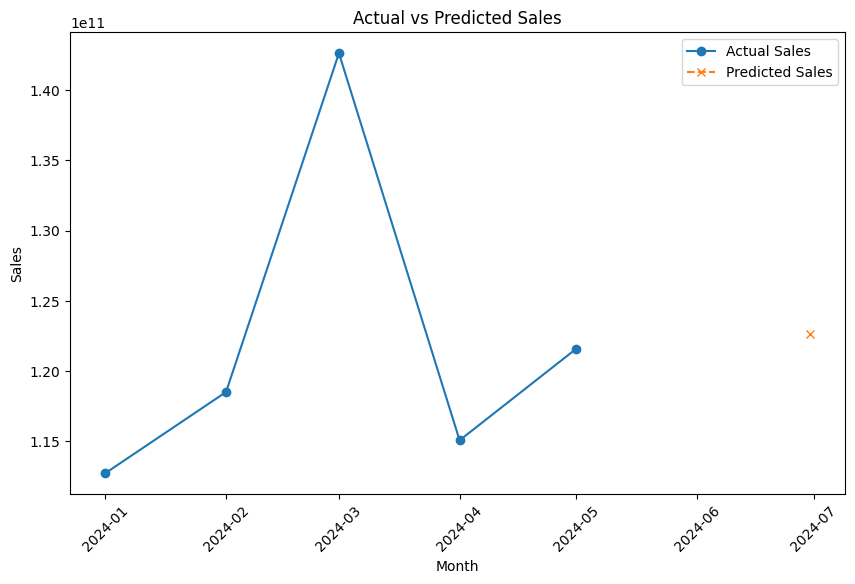

In [276]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Sample monthly data
data = {
    'month': ['2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05'],
    'total_revenue': [108407589878, 112732159295, 118510679557, 142635556169, 115071446043, 121597997261]
}

# Create DataFrame
monthly_data = pd.DataFrame(data)

# Convert 'month' to datetime format
monthly_data['month'] = pd.to_datetime(monthly_data['month'], format='%Y-%m')

# Calculate the difference in sales (month-to-month difference)
monthly_data['sales_diff'] = monthly_data['total_revenue'].diff()

# Drop the first row since diff() will create a NaN for the first value
monthly_data = monthly_data.dropna()

# Fit ARIMA model to the sales_diff
model = sm.tsa.ARIMA(monthly_data['sales_diff'], order=(1, 0, 0))  # ARIMA(p, d, q), with simple (1, 0, 0) parameters
model_fit = model.fit()

# Predict the next few months (e.g., next 1 month)
forecast_steps = 1
forecast_diff = model_fit.forecast(steps=forecast_steps)

# Predict future sales using the forecasted differences
# For the first forecasted value, we need to add the forecasted diff to the last known sales
predicted_sales = []
last_known_sales = monthly_data['total_revenue'].iloc[-1]

for diff in forecast_diff:
    predicted_sales.append(last_known_sales + diff)
    last_known_sales += diff  # Update the last known sales

# Create a DataFrame for the forecasted months
forecast_months = pd.date_range(start=monthly_data['month'].iloc[-1], periods=forecast_steps + 1, freq='M')[1:]

forecast_df = pd.DataFrame({
    'month': forecast_months,
    'predicted_sales': predicted_sales
})

# Display the forecast
print(forecast_df)

# Plot the actual and predicted sales
plt.figure(figsize=(10, 6))
plt.plot(monthly_data['month'], monthly_data['total_revenue'], label='Actual Sales', marker='o')
plt.plot(forecast_df['month'], forecast_df['predicted_sales'], label='Predicted Sales', marker='x', linestyle='--')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [273]:
import statsmodels.api as sm


In [267]:
# Create DataFrame
monthly_data = pd.DataFrame(data)

# Calculate the difference in sales (month-to-month difference)
monthly_data['sales_diff'] = monthly_data['total_revenue'].diff()

# Drop the first row since diff() will create a NaN for the first value
monthly_data = monthly_data.dropna()

# Fit ARIMA model to the sales_diff
model = sm.tsa.ARIMA(monthly_data['sales_diff'], order=(1, 0, 0))  # ARIMA(p, d, q), with simple (1, 0, 0) parameters
model_fit = model.fit()

# Predict the next few months (e.g., next 3 months)
forecast_steps = 3
forecast_diff = model_fit.forecast(steps=forecast_steps)

# Predict future sales using the forecasted differences
# For the first forecasted value, we need to add the forecasted diff to the last known sales
predicted_sales = []
last_known_sales = monthly_data['total_revenue'].iloc[-1]

for diff in forecast_diff:
    predicted_sales.append(last_known_sales + diff)
    last_known_sales += diff  # Update the last known sales

# Create a DataFrame for the forecasted months
forecast_months = pd.date_range(start=monthly_data['month'].iloc[-1], periods=forecast_steps + 1, freq='M')[1:]

forecast_df = pd.DataFrame({
    'month': forecast_months,
    'predicted_sales': predicted_sales
})

# Display the forecast
print(forecast_df)

# Plot the actual and predicted sales
plt.figure(figsize=(10, 6))
plt.plot(monthly_data['month'], monthly_data['total_revenue'], label='Actual Sales', marker='o')
plt.plot(forecast_df['month'], forecast_df['predicted_sales'], label='Predicted Sales', marker='x', linestyle='--')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.xticks(rotation=45)
plt.show()

NameError: name 'data' is not defined

In [263]:
supervised_data = monthly_data.drop(['month','total_revenue'], axis=1)

In [259]:
print(supervised_data.head(10))


    total_order  total_pickup  total_delivery  total_pickup_delivery  \
2      11715135      11508564        11090374               22598938   
3      13554745      13051053        12785333               25836386   
4      10657935      10728960        10670322               21399282   
5      11878057      11698490        11675577               23374067   
6      11385578      11910968        10986575               22084943   
7      12819344      12606959        12172495               24779454   
8      13411845      13286769        13405685               26692454   
9      13464080      13247899        12980604               26228503   
10     14148327      14000089        14083839               28083928   
11     13667724      13438907        13099765               26538672   

    total_cancel  total_bookings       PnL_rev  Holiday  Twin Date  \
2         162579        11545089  118788641817        1          1   
3         203351        13611539  144010788390        1          1 

In [258]:
# Shift the 'sales_diff' by 1 to 12 months
for i in range(1, 11):
    col_name = 'month' + str(i)
    supervised_data[col_name] = monthly_data['sales_diff'].shift(periods=i)

# Drop rows where any of the new columns (month1 to month12) have NaN
supervised_data = supervised_data.dropna(subset=[f'month{i}' for i in range(1, 12)]).reset_index(drop=True)

# Check the first few rows after dropping NaNs
supervised_data.head(10)

print(supervised_data.isna().sum())
print(supervised_data.head(10))


KeyError: ['month11']

<class 'pandas.core.frame.DataFrame'>


In [223]:
for i in range (1,13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(periods=i) # Call the shift method with periods argument
supervised_data = supervised_data.dropna().reset_index(drop=True) # Reset index and drop the old index
supervised_data.head(10)

TypeError: 'method' object is not subscriptable

In [257]:
supervised_data['sales_diff'] = supervised_data['total_revenue'].diff()

for i in range(1, 11):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(periods=i)

supervised_data = supervised_data.dropna().reset_index(drop=True)
print(supervised_data.head(10))


KeyError: 'total_revenue'

# Daily Pred

In [46]:
df.value_counts()

,,,,,,,,,,,count
tanggal,total_order,total_pickup,total_delivery,total_pickup_delivery,total_cancel,total_bookings,total_revenue,PnL_rev,Holiday,Twin Date,
2023-12-01,355401,329764,321474,651238,6104,356143,3235842325,3253848075,0,0,1
2024-08-08,807753,651243,511881,1163124,9295,811515,5499801582,5527585192,0,1,1
2024-08-06,465721,495904,474680,970584,4745,466107,4791076015,4815279322,0,0,1
2024-08-05,599098,693706,594492,1288198,9132,597572,6527519137,6560494516,0,0,1
2024-08-04,255095,68399,15985,84384,4677,262929,384058625,385998792,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-30,503399,523032,524191,1047223,7017,500734,5885269075,5942012371,0,0,1
2024-03-29,418730,408933,566540,975473,11460,424771,5932029177,5989223315,1,0,1
2024-03-28,488498,499708,601591,1101299,8608,483654,6239698266,6299858820,0,0,1


In [163]:
# Day of the week
# Ensure 'tanggal' column is in datetime format before using .dt accessor
df['tanggal'] = pd.to_datetime(df['tanggal'])
df['day_of_week'] = df['tanggal'].dt.dayofweek

# Binary indicator for weekend
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

In [165]:
df.to_excel('komplitdf.xlsx')

In [162]:
X.to_excel('clean_df.xlsx')

In [129]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Define features and target
features = ['total_order', 'total_pickup', 'total_delivery', 'total_pickup_delivery', 'total_cancel', 'total_bookings', 'Holiday', 'Twin Date', 'is_weekend']
target = 'total_revenue'

# Prepare data
X = df[features]
y = df[target]

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize the model
XGBmodel = XGBRegressor(n_estimators=200, learning_rate=0.05)

# Train the model
XGBmodel.fit(X_train, y_train)

# Evaluate the model
y_pred = XGBmodel.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 295184595.0135135
Root Mean Squared Error (RMSE): 404284370.7602007


In [130]:
y_pred

array([5.1453844e+09, 5.3131587e+09, 5.4911918e+09, 4.2168369e+09,
       4.2266285e+08, 6.0149740e+09, 4.6939535e+09, 4.7487324e+09,
       5.5714734e+09, 5.4040535e+09, 5.0730788e+09, 4.0409235e+08,
       5.8216878e+09, 4.5220260e+09, 4.9979909e+09, 5.7619430e+09,
       5.0338089e+09, 4.2716378e+09, 3.9552854e+08, 5.8925619e+09,
       4.7683758e+09, 5.3874176e+09, 5.7098865e+09, 5.5603195e+09,
       5.6322212e+09, 3.1226209e+09, 7.1311150e+09, 5.2569196e+09,
       5.3337165e+09, 5.4613627e+09, 4.8675062e+09, 4.3839508e+09,
       3.6019456e+08, 5.7096141e+09, 4.4589763e+09, 5.0307789e+09,
       5.1923697e+09, 4.6436618e+09, 4.4141763e+09, 3.7502982e+08,
       6.3338127e+09, 5.0157486e+09, 4.9880274e+09, 5.2368584e+09,
       4.6452193e+09, 4.3400049e+09, 3.8144195e+08, 6.0874706e+09,
       4.6608456e+09, 5.3313500e+09, 5.5146086e+09, 5.0531487e+09,
       4.4197012e+09, 4.0780358e+08, 5.8364339e+09, 4.7022346e+09,
       5.5198505e+09, 7.0655872e+09, 6.0679112e+09, 6.5218156e

In [131]:
import pandas as pd

# Get feature importance
feature_importance = XGBmodel.feature_importances_

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance report
print(importance_df)

                 Feature  Importance
1           total_pickup    0.794169
2         total_delivery    0.152723
3  total_pickup_delivery    0.020007
4           total_cancel    0.009246
8             is_weekend    0.006979
0            total_order    0.006783
6                Holiday    0.004311
5         total_bookings    0.004098
7              Twin Date    0.001684


In [132]:
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

R-squared: 0.9483423829078674


In [134]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Define features and target
features = ['total_order', 'total_pickup', 'total_delivery', 'total_pickup_delivery', 'total_cancel', 'total_bookings', 'Holiday', 'Twin Date', 'is_weekend']
target = 'total_revenue'

# Prepare data
X = df[features]
y = df[target]

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Impute missing values using the mean
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or other strategies
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor())
]

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f'{name} R²: {r2}')


# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Linear Regression R²: 0.9660959929040621
Random Forest R²: 0.9644045095701471
Mean Absolute Error (MAE): 244104849.05635136
Root Mean Squared Error (RMSE): 335596388.1854964


In [136]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f'{name} R²: {r2}')
    print(f'{name} Mean Absolute Error (MAE): {mae}')
    print(f'{name} Root Mean Squared Error (RMSE): {rmse}')
    print('-' * 30)


Linear Regression R²: 0.9660959929040621
Linear Regression Mean Absolute Error (MAE): 247448551.03329948
Linear Regression Root Mean Squared Error (RMSE): 327525639.1289694
------------------------------
Random Forest R²: 0.9602984538805606
Random Forest Mean Absolute Error (MAE): 258914227.83824322
Random Forest Root Mean Squared Error (RMSE): 354424306.0428992
------------------------------


# prophet

In [54]:
!pip install fbprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 20.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
  Running setup.py clean for fbprophet
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732003 sha256=ebdf20831ea65263e0302e2b8e26c80ca39ba42400dfd65675e25a7d18525abc
  Stored in directory: /root/.cache/pip/wheels/d6/67/7

In [55]:
!apt-get update
!apt-get install build-essential

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [60.9 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,545 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Package

In [56]:
!apt-get install libgomp1

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgomp1 is already the newest version (12.3.0-1ubuntu1~22.04).
libgomp1 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.


In [57]:
!CC=gcc CXX=g++ pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl.metadata (2.9 kB)
  Using cached pystan-3.10.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata (6.3 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Using cached clikit-0.6.2-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached pysimdjson-6.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.9 kB)
  Using cached crashtest-0.3.1-py3-none-any.whl.metadata (748 bytes)
  Using cached pastel-0.2.1-py2.py3-none-any.whl.metadata (1.9 kB)
  Using cached pylev-1.4.0-py2.py3-none-any.whl.metadata (2.3 kB)
Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
Using cached LunarCalendar-0.0.9-

In [58]:
!pip install ephem

In [59]:
!pip install --no-cache-dir fbprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 66.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 140.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 186.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
  Running setup.py clean for fbprophet
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732003 sha256=185dcc554c6ade3c0213575ac81b87d2d4b7d063fe036b4bd161119e13dfd8a6
  Stored in directory: /tmp/pip-ephem-wheel-cache

In [60]:
!pip install httpstan

In [61]:
!pip install --no-cache-dir prophet

In [62]:
!pip install pystan==2.19.1.1

  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pystan
  Running setup.py clean for pystan
Failed to build pystan
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pystan)


In [63]:
from prophet import Prophet

# Instantiate Prophet with cmdstanpy backend
model = Prophet(stan_backend='CMDSTANPY')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptziw5gfh/84psefxs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptziw5gfh/i44e81rm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56186', 'data', 'file=/tmp/tmptziw5gfh/84psefxs.json', 'init=/tmp/tmptziw5gfh/i44e81rm.json', 'output', 'file=/tmp/tmptziw5gfh/prophet_modely_fx2rrn/prophet_model-20241217133559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


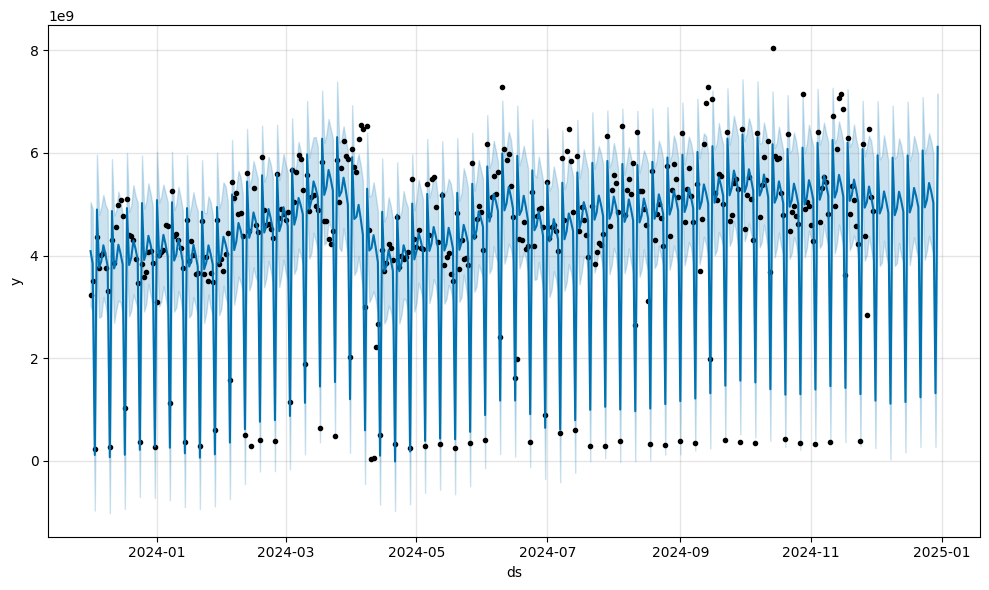

In [64]:
# Prepare data for Prophet (column names must be 'ds' for dates and 'y' for target values)
df_prophet = df[['tanggal', 'total_revenue']].reset_index()  # Include 'tanggal' in the selection
df_prophet.rename(columns={'tanggal': 'ds', 'total_revenue': 'y'}, inplace=True)

# Initialize and fit the model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(df_prophet)

# Make future predictions
future = model.make_future_dataframe(periods=30)  # Forecast for the next 30 days
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.show()

In [65]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Example: Actual data vs predictions
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-Squared: {r2}")


Mean Absolute Error (MAE): 197537333.17513514
Root Mean Squared Error (RMSE): 263653470.00241804
R-Squared: 0.978030134013439


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


* ds: future dates (including past
and future)
* yhat: predicted value of target variable (total revenue in this case)
* yhat_lower and yhat_upper: The lower and upper bounds of the prediction, showing the uncertainty range.

In [66]:
# Format the numbers for better readability
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].applymap(lambda x: f'{x:,.2f}' if isinstance(x, (int, float)) else x)

# View the last few predicted values with improved readability
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


            ds              yhat        yhat_lower        yhat_upper
391 2024-12-26  5,413,882,368.77  4,383,630,682.61  6,384,013,226.26
392 2024-12-27  5,244,959,970.85  4,199,632,345.62  6,216,381,200.62
393 2024-12-28  5,029,184,350.43  4,002,163,138.04  5,991,659,735.32
394 2024-12-29  1,318,131,838.53    267,890,553.03  2,346,875,108.02
395 2024-12-30  6,117,787,385.23  5,158,708,659.12  7,155,272,202.44


<ipython-input-66-6764d3cfa22d>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].applymap(lambda x: f'{x:,.2f}' if isinstance(x, (int, float)) else x)


In [67]:
print(forecast.columns)


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


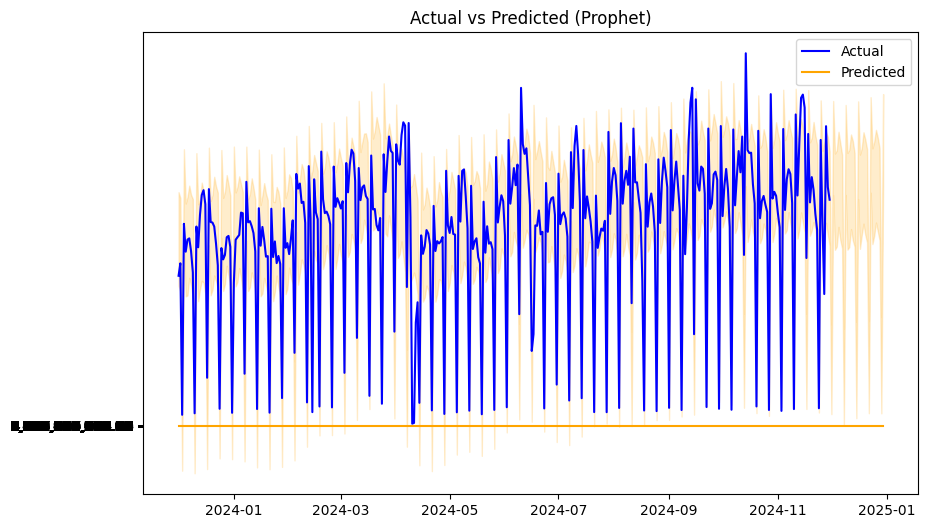

In [68]:
# Merge the forecast with actual data
actuals = df[['tanggal', 'total_revenue']].rename(columns={'tanggal': 'ds', 'total_revenue': 'y'}) # Change 'ds' to 'tanggal'
# Include 'yhat_lower' and 'yhat_upper' in the merge
comparison = pd.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], actuals, on='ds', how='left')

# Convert 'yhat_lower' and 'yhat_upper' back to numeric if needed
comparison['yhat_lower'] = pd.to_numeric(comparison['yhat_lower'].str.replace(',', ''))
comparison['yhat_upper'] = pd.to_numeric(comparison['yhat_upper'].str.replace(',', ''))

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(comparison['ds'], comparison['y'], label='Actual', color='blue')
plt.plot(comparison['ds'], comparison['yhat'], label='Predicted', color='orange')
plt.fill_between(comparison['ds'], comparison['yhat_lower'], comparison['yhat_upper'], color='orange', alpha=0.2)
plt.legend()
plt.title('Actual vs Predicted (Prophet)')
plt.show()

In [69]:
forecast.to_csv('forecast.csv', index=False)

In [70]:
from prophet import Prophet
import pandas as pd

# Assuming indonesia_holidays is your holidays.Indonesia object
holidays_df = pd.DataFrame(list(indonesia_holidays.items()), columns=['ds', 'holiday'])

# Instantiate Prophet with cmdstanpy backend and the holidays DataFrame
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    holidays=holidays_df  # Pass the DataFrame to holidays argument
    #stan_backend='CMDSTANPY'  # Uncomment if CMDSTANPY backend is desired
)

In [71]:
# test data test
X_test

array([[4.43606000e+05, 4.80487000e+05, 4.74029000e+05, 9.54516000e+05,
        5.43500000e+03, 4.43701000e+05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.67878526e+09, 5.22797731e+09],
       [4.16760000e+05, 4.33240000e+05, 5.26840000e+05, 9.60080000e+05,
        4.92300000e+03, 4.19024000e+05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.59644846e+09, 5.07325178e+09],
       [3.89810000e+05, 3.93913000e+05, 4.99080000e+05, 8.92993000e+05,
        9.14000000e+03, 3.96155000e+05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.39201435e+09, 5.59166990e+09],
       [3.44562000e+05, 3.57824000e+05, 4.42417000e+05, 8.00241000e+05,
        4.91500000e+03, 3.45706000e+05, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 5.06522630e+09, 5.54236384e+09],
       [2.32071000e+05, 5.97640000e+04, 2.06420000e+04, 8.04060000e+04,
        3.53900000e+03, 2.41179000e+05, 1.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 4.84080801e+09, 5.00395133e+

In [72]:
print(features)

['total_order', 'total_pickup', 'total_delivery', 'total_pickup_delivery', 'total_cancel', 'total_bookings', 'Holiday', 'Twin Date', 'is_weekend', 'rolling_avg_7', 'prev_day_sales']


In [73]:
# X_test.to_excel('X_test.xlsx')

AttributeError: 'numpy.ndarray' object has no attribute 'to_excel'

In [74]:
# Manually input the test data @ row 376
tes_data = pd.DataFrame({
    'total_order': [517088],
    'total_pickup': [451696],
    'total_delivery': [507910],
    'total_pickup_delivery': [959606],
    'total_cancel': [105275],
    'total_bookings': [518884],
    'Holiday': [0],  # This might be binary: 0 for non-holiday, 1 for holiday
    'Twin Date': [0],  # 0 or 1 for twin date feature
    'is_weekend': [0],  # 0 for weekdays, 1 for weekends
    'rolling_avg_7': [5150701028],
    'prev_day_sales': [5207720658]
})
# Get the prediction for the single data point
prediction = XGBmodel.predict(tes_data)
print("Prediction for single data point:", prediction)


Prediction for single data point: [5.4530135e+09]


In [75]:
# Manually input the test data @ row 376
tes_data = pd.DataFrame({
    'total_order': [517088],
    'total_pickup': [451696],
    'total_delivery': [507910],
    'total_pickup_delivery': [959606],
    'total_cancel': [105275],
    'total_bookings': [518884],
    'Holiday': [0],  # This might be binary: 0 for non-holiday, 1 for holiday
    'Twin Date': [0],  # 0 or 1 for twin date feature
    'is_weekend': [0],  # 0 for weekdays, 1 for weekends
    'rolling_avg_7': [5150701028],
    'prev_day_sales': [5207720658]
})
# Get the prediction for the single data point
prediction = XGBmodel.predict(tes_data)
print("Prediction for single data point:", prediction)


Prediction for single data point: [5.4530135e+09]


In [76]:
test_data = pd.DataFrame({
    'total_order': [422.898],
    'total_pickup': [435.715],
    'total_delivery': [521.283],
    'total_pickup_delivery': [956.998],
    'total_cancel': [7.455],
    'total_bookings': [423.889],
    'Holiday': [0],  # Assuming no holiday (if missing, you can set it to 0 or another neutral value)
    'Twin Date': [0],  # Assuming no twin date (if missing, set it to 0)
    'is_weekend': [0],  # Assuming it's not a weekend (if missing, set it to 0)
    'rolling_avg_7': [5044211392],  # Corrected to avoid periods in the number
    'prev_day_sales': [6084538977]  # Corrected to avoid periods in the number
})
# Get the prediction for the single data point
prediction = XGBmodel.predict(tes_data)
print("Prediction for single data point:", prediction)

# For float numbers
number = 5.505365e+09
formatted_number = f"{number:,.0f}"
print(formatted_number)



Prediction for single data point: [5.4530135e+09]
5,505,365,000


In [77]:
test_data = pd.DataFrame({
    'total_order': [416391],
    'total_pickup': [428702],
    'total_delivery': [517654],
    'total_pickup_delivery': [946356],
    'total_cancel': [5411],
    'total_bookings': [415795],
    'Holiday': [0],  # Assuming no holiday (if missing, you can set it to 0 or another neutral value)
    'Twin Date': [0],  # Assuming no twin date (if missing, set it to 0)
    'is_weekend': [0],  # Assuming it's not a weekend (if missing, set it to 0)
    'rolling_avg_7': [4600533911],  # Corrected format (removed periods)
    'prev_day_sales': [5422425224]  # Corrected format (removed periods)
})

# Load or use your trained model
# Assuming you have already trained the model or loaded a saved one
model = XGBRegressor()  # Example, replace with actual model
# model.fit(X_train, y_train)  # If you haven't trained yet, use this line

# Make the prediction for the test data
prediction = XGBmodel.predict(test_data)
print("Prediction:", prediction)


Prediction: [5.5280824e+09]


In [78]:
result = 5.4797594e+09
formatted_result = "Prediction for single data point: {:,.0f}".format(result)
print(formatted_result)

Prediction for single data point: 5,479,759,400


In [79]:
test_data = pd.DataFrame({
    'total_order': [416391],
    'total_pickup': [425000],
    'total_delivery': [517654],
    'total_pickup_delivery': [946356],
    'total_cancel': [5000],
    'total_bookings': [415795],
    'Holiday': [0],  # Assuming no holiday (if missing, you can set it to 0 or another neutral value)
    'Twin Date': [0],  # Assuming no twin date (if missing, set it to 0)
    'is_weekend': [0],  # Assuming it's not a weekend (if missing, set it to 0)
    'rolling_avg_7': [4600533911],  # Corrected format (removed periods)
    'prev_day_sales': [5422425224]  # Corrected format (removed periods)
})

# Load or use your trained model
# Assuming you have already trained the model or loaded a saved one
model = XGBRegressor()  # Example, replace with actual model
# model.fit(X_train, y_train)  # If you haven't trained yet, use this line

# Make the prediction for the test data
prediction = XGBmodel.predict(test_data)
print("Prediction:", prediction)


Prediction: [5.5264906e+09]


In [80]:
# Assuming y_pred is your numpy array
y_pred_df = pd.DataFrame(y_pred, columns=['Predictions'])  # Create a DataFrame

# Now you can use to_excel:
y_pred_df.to_excel('y_pred.xlsx', index=False)  # Save to Excel, index=True to avoid row numbers

# Deploy

In [167]:
file_path2 = '/content/test_decemberv1.1.xlsx'
test_df = pd.read_excel(file_path2)
test_df

,tanggal,total_order,total_pickup,total_delivery,total_pickup_delivery,total_cancel,total_bookings,total_revenue,PnL_rev,Holiday,Twin Date,is_weekend
0,2024-12-01,291794,66613,17243,83856,6100,300127,388681464,0,1,0,1
1,2024-12-02,623859,721715,609827,1331542,8075,622434,7146889893,0,0,0,0
2,2024-12-03,701728,535067,489428,1024495,4850,702868,5422519873,0,0,0,0
3,2024-12-04,528492,488458,515783,1004241,5196,530436,5450490040,0,0,0,0
4,2024-12-05,456386,459493,547783,1007276,14008,458249,6084538977,0,0,0,0
5,2024-12-06,422898,435715,521283,956998,7455,423889,5940059765,0,0,0,0
6,2024-12-07,369619,391225,452902,844127,5999,370221,5564260039,0,0,0,1
7,2024-12-08,246511,62398,40372,102770,4224,253987,671956037,0,1,0,1
8,2024-12-09,594063,680102,543213,1223315,7804,592866,6890170467,0,0,0,0
9,2024-12-10,468941,492933,463592,956525,5454,470406,5207720658,0,0,0,0


In [168]:
X_test_df = pd.DataFrame(X_test, columns=features)  # Assuming 'features' contains your column names
X_test_df.to_excel('x_test.xlsx', index=False)  # index=False to avoid row numbers in Excel

In [169]:
test_df.value_counts()

,,,,,,,,,,,,count
tanggal,total_order,total_pickup,total_delivery,total_pickup_delivery,total_cancel,total_bookings,total_revenue,PnL_rev,Holiday,Twin Date,is_weekend,
2024-12-01,291794,66613,17243,83856,6100,300127,388681464,0,1,0,1,1
2024-12-02,623859,721715,609827,1331542,8075,622434,7146889893,0,0,0,0,1
2024-12-03,701728,535067,489428,1024495,4850,702868,5422519873,0,0,0,0,1
2024-12-04,528492,488458,515783,1004241,5196,530436,5450490040,0,0,0,0,1
2024-12-05,456386,459493,547783,1007276,14008,458249,6084538977,0,0,0,0,1
2024-12-06,422898,435715,521283,956998,7455,423889,5940059765,0,0,0,0,1
2024-12-07,369619,391225,452902,844127,5999,370221,5564260039,0,0,0,1,1
2024-12-08,246511,62398,40372,102770,4224,253987,671956037,0,1,0,1,1
2024-12-09,594063,680102,543213,1223315,7804,592866,6890170467,0,0,0,0,1


In [170]:
test_df.dtypes

,0
tanggal,datetime64[ns]
total_order,int64
total_pickup,int64
total_delivery,int64
total_pickup_delivery,int64
total_cancel,int64
total_bookings,int64
total_revenue,int64
PnL_rev,int64
Holiday,int64


In [176]:
XGB_dec = XGBmodel.predict(test_df)
print('XGB Predictions for December 2024:')
print(XGB_dec)
print('-' * 30)

XGB Predictions for December 2024:
[4.1172819e+08 6.5450947e+09 4.7365852e+09 5.0683802e+09 5.8671427e+09
 5.7229614e+09 5.0561393e+09 5.8154042e+08 6.0830413e+09 5.1297505e+09
 5.5532140e+09]
------------------------------


In [171]:
# Drop any datetime columns and ensure correct order of features
test_df = test_df[features]  # Keep only the columns used during training

# Train models on all data and predict for December 2024
X_all = X  # Use all available data for training
y_all = y

for name, model in models:
    model.fit(X_all, y_all)  # Train model on all data
    y_dec_2024 = model.predict(test_df)  # Predict December 2024
    print(f'{name} Predictions for December 2024:')
    print(y_dec_2024)
    print('-' * 30)

Linear Regression Predictions for December 2024:
[3.86360515e+08 6.49034955e+09 5.16926498e+09 5.42610493e+09
 5.83202481e+09 5.48813796e+09 4.89255006e+09 5.89258025e+08
 5.82637392e+09 4.93975311e+09 6.52717217e+09]
------------------------------
Random Forest Predictions for December 2024:
[3.68214686e+08 6.37917599e+09 4.93053711e+09 5.34077867e+09
 5.74835864e+09 5.67116870e+09 5.00585812e+09 5.33959950e+08
 6.30218891e+09 5.01703734e+09 5.56085540e+09]
------------------------------


In [ ]:
# Predictions from both models
lr_predictions = [3.86360515e+08, 6.49034955e+09, 5.16926498e+09, 5.42610493e+09,
                  5.83202481e+09, 5.48813796e+09, 4.89255006e+09, 5.89258025e+08,
                  5.82637392e+09, 4.93975311e+09, 6.52717217e+09]

rf_predictions = [3.68214686e+08, 6.37917599e+09, 4.93053711e+09, 5.34077867e+09,
                  5.74835864e+09, 5.67116870e+09, 5.00585812e+09, 5.33959950e+08,
                  6.30218891e+09, 5.01703734e+09, 5.56085540e+09]



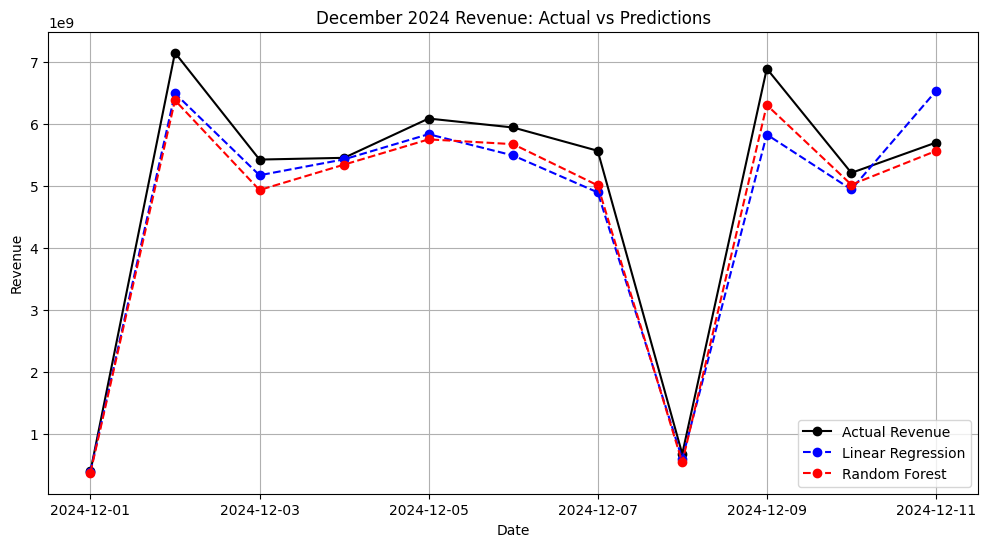

In [177]:
import pandas as pd
import matplotlib.pyplot as plt

# Dates for December 2024
dates = pd.date_range(start='2024-12-01', periods=11, freq='D')

# Predictions from both models
lr_predictions = [3.86360515e+08, 6.49034955e+09, 5.16926498e+09, 5.42610493e+09,
                  5.83202481e+09, 5.48813796e+09, 4.89255006e+09, 5.89258025e+08,
                  5.82637392e+09, 4.93975311e+09, 6.52717217e+09]

rf_predictions = [3.68214686e+08, 6.37917599e+09, 4.93053711e+09, 5.34077867e+09,
                  5.74835864e+09, 5.67116870e+09, 5.00585812e+09, 5.33959950e+08,
                  6.30218891e+09, 5.01703734e+09, 5.56085540e+09]

# Actual revenue data
actual_revenue = [388681464, 7146889893, 5422519873, 5450490040,
                  6084538977, 5940059765, 5564260039, 671956037,
                  6890170467, 5207720659, 5696201255]

# Create a DataFrame to organize data
results_df = pd.DataFrame({
    'Date': dates,
    'Actual Revenue': actual_revenue,
    'Linear Regression': lr_predictions,
    'Random Forest': rf_predictions
})

# Plot the data
plt.figure(figsize=(12, 6))

# Actual data
plt.plot(results_df['Date'], results_df['Actual Revenue'], color='black', linestyle='-', marker='o', label='Actual Revenue')

# Predictions
plt.plot(results_df['Date'], results_df['Linear Regression'], color='blue', linestyle='--', marker='o', label='Linear Regression')
plt.plot(results_df['Date'], results_df['Random Forest'], color='red', linestyle='--', marker='o', label='Random Forest')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('December 2024 Revenue: Actual vs Predictions')
plt.legend()

# Display the grid
plt.grid()
plt.show()


In [ ]:
test_df['tanggal'] = pd.to_numeric(pd.to_datetime(test_df['tanggal'])) #convert to unix timestamp

In [178]:
XGBmodel.predict(test_df)


array([4.1172819e+08, 6.5450947e+09, 4.7365852e+09, 5.0683802e+09,
       5.8671427e+09, 5.7229614e+09, 5.0561393e+09, 5.8154042e+08,
       6.0830413e+09, 5.1297505e+09, 5.5532140e+09], dtype=float32)

In [181]:
import pandas as pd

# Generate dates from today until 31 December
future_dates = pd.date_range(start='2024-12-12', end='2024-12-31', freq='D')

# Create a DataFrame for future dates
future_data = pd.DataFrame({
    'date': future_dates
})

# Add features like 'day', 'month', 'weekday', etc.
future_data['day'] = future_data['date'].dt.day
future_data['month'] = future_data['date'].dt.month
future_data['weekday'] = future_data['date'].dt.weekday

# Add any other features your model needs (e.g., previous revenue, special events)
future_data['double_date'] = future_data['day'].isin([2, 12, 22])  # Example of double dates

# Now you have features for predictions from Dec 1 to Dec 31


In [182]:
future_data

,date,day,month,weekday,double_date
0,2024-12-12,12,12,3,True
1,2024-12-13,13,12,4,False
2,2024-12-14,14,12,5,False
3,2024-12-15,15,12,6,False
4,2024-12-16,16,12,0,False
5,2024-12-17,17,12,1,False
6,2024-12-18,18,12,2,False
7,2024-12-19,19,12,3,False
8,2024-12-20,20,12,4,False
9,2024-12-21,21,12,5,False


In [198]:
import pandas as pd

# Generate dates from today until 31 December
future_dates = pd.date_range(start='2024-12-12', end='2024-12-31', freq='D')

# Create a DataFrame for future dates
future_data = pd.DataFrame({
    'date': future_dates
})

# Add features like 'day', 'month', 'weekday', etc.
future_data['day'] = future_data['date'].dt.day
future_data['month'] = future_data['date'].dt.month
future_data['weekday'] = future_data['date'].dt.weekday
future_data['is_weekend'] = future_data['weekday'].isin([5, 6]).astype(int)
future_data['double_date'] = future_data['day'].isin([12])  # Example of double dates

# Add any other features your model needs (e.g., previous revenue, special events)
future_data['double_date'] = future_data['day'].isin([12])  # Example of double dates

# Add missing features, please input reasonable values
future_data['total_order'] = [291794] * len(future_data)
future_data['total_pickup'] = [66613] * len(future_data)
future_data['total_delivery'] = [17243] * len(future_data)
future_data['total_pickup_delivery'] = [83856] * len(future_data)
future_data['total_cancel'] = [6100] * len(future_data)
future_data['total_bookings'] = [300127] * len(future_data)
future_data['Holiday'] = [6] * len(future_data)  # Input actual holiday values
future_data['Twin Date'] = [0] * len(future_data)  # Input actual twin date values
future_data['is_weekend'] = [3] * len(future_data)  # Input actual twin date values

# Now you have features for predictions from Dec 1 to Dec 31

In [199]:
model

RandomForestRegressor()

In [206]:
predicted_values =  rf_predictions # Use a list to store prediction values

for i in range(0, len(future_data)):  # Loop for each future day
    # Prepare the input for the next day's prediction (use today's predicted value)
    X_next_day = future_data.iloc[[i]]  # Make sure to include the predicted value as input
    X_next_day = X_next_day[['total_order', 'total_pickup', 'total_delivery', 'total_pickup_delivery', 'total_cancel', 'total_bookings', 'Holiday', 'Twin Date', 'is_weekend']]
    next_prediction = model.predict(X_next_day)[0]  # Predict for the next day

    predicted_values.append(next_prediction)  # Append the predicted value
    future_data.at[i, 'predicted_revenue'] = next_prediction  # Store the prediction for

In [205]:
print("Predicted Revenue for December 2024:")
for index, row in future_data.iterrows():
    print(f"{row['date'].strftime('%Y-%m-%d')}: {row['predicted_revenue']:,.2f}")

Predicted Revenue for December 2024:
2024-12-12: 368,214,685.84
2024-12-13: 368,214,685.84
2024-12-14: 368,214,685.84
2024-12-15: 368,214,685.84
2024-12-16: 368,214,685.84
2024-12-17: 368,214,685.84
2024-12-18: 368,214,685.84
2024-12-19: 368,214,685.84
2024-12-20: 368,214,685.84
2024-12-21: 368,214,685.84
2024-12-22: 368,214,685.84
2024-12-23: 368,214,685.84
2024-12-24: 368,214,685.84
2024-12-25: 368,214,685.84
2024-12-26: 368,214,685.84
2024-12-27: 368,214,685.84
2024-12-28: 368,214,685.84
2024-12-29: 368,214,685.84
2024-12-30: 368,214,685.84
2024-12-31: 368,214,685.84


In [202]:
# Assume this is the actual value for today (e.g., net revenue for today)
actual_value_for_today = 5696201255  # Replace with your actual value

# Use this to start the predictions
predicted_values = [actual_value_for_today]

for i in range(1, len(future_data)):  # Loop through future data points
    # Use the predicted value from the previous day as input for the next day
    X_next_day = future_data.iloc[i]  # Make sure this includes the necessary features
    X_next_day['previous_day_revenue'] = predicted_values[-1]  # Add predicted revenue as a feature

    # Predict the revenue for the next day
    next_prediction = model.predict(X_next_day)

    # Append the predicted value for the next day
    predicted_values.append(next_prediction)

    # Store the prediction in the future_data DataFrame
    future_data.at[i, 'predicted_revenue'] = next_prediction


<ipython-input-202-9363d58f2219>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_next_day['previous_day_revenue'] = predicted_values[-1]  # Add predicted revenue as a feature
<ipython-input-202-9363d58f2219>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_next_day['previous_day_revenue'] = predicted_values[-1]  # Add predicted revenue as a feature
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [88]:
import holidays
import datetime # Import the datetime module

# Get Indonesian holidays for a specific year (e.g., 2024)
indonesia_holidays = holidays.Indonesia(years=2024)

# Print all holidays
for date, name in sorted(indonesia_holidays.items()):
    print(date, name)

# Example: Check if a given date is a holiday
def is_holiday(date):
    for holiday in indonesia_holidays:
        if holiday[0] == date:
            return holiday[1]
    return None

# Function to check if a date is a holiday
def check (date):
    # Convert the pandas Timestamp to a datetime.date object
    date_object = date.to_pydatetime().date()
    return "Holiday" if date_object in indonesia_holidays else "Not Holiday"

# Apply the function to create the 'Holiday' column
test_df['Holiday'] = df['tanggal'].apply(check)

# Display the DataFrame
print(df)

2024-01-01 New Year's Day
2024-02-08 Isra' and Mi'raj
2024-02-10 Lunar New Year
2024-02-14 General Election Day
2024-03-11 Day of Silence
2024-03-29 Good Friday
2024-03-31 Easter Sunday
2024-04-10 Eid al-Fitr
2024-04-11 Eid al-Fitr Second Day
2024-05-01 International Labor Day
2024-05-09 Ascension Day
2024-05-23 Vesak Day
2024-06-01 Pancasila Day
2024-06-17 Eid al-Adha
2024-07-07 Islamic New Year
2024-08-17 Independence Day
2024-09-16 Prophet's Birthday
2024-11-27 Local Election Day
2024-12-25 Christmas Day
       tanggal  total_order  total_pickup  total_delivery  \
0   2023-12-01       355401        329764          321474   
1   2023-12-02       328939        336808          377766   
2   2023-12-03       205178         49381           13179   
3   2023-12-04       545267        600819          435942   
4   2023-12-05       404052        440086          422757   
..         ...          ...           ...             ...   
361 2024-11-26       498380        540092          409349   

In [ ]:
# Menampilkan hasil prediksi
for day, revenue in enumerate(predictions, start=1):
    print(f"Prediksi Revenue 2024-12-{day:02d}: {revenue:,.2f}")